In [1]:
!pip install aenum lightly lightly-train ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.1 MB/s eta 0:00:00


In [2]:
# ================================================================
# Kaggle Notebook: DINOv3 (SSL) + YOLOv11 for Rice Panicle (COCO → YOLO)
# - Uses your COCO dataset, converts to YOLO format
# - Optional SSL pretrain via LightlyTrain (DINOv3 distillation → YOLOv11)
# - Fine-tunes YOLOv11 on YOLO labels
# - mAP eval + sample visualizations
# - Kaggle-safe (num_workers=0)
# ================================================================

# %% [setup]
import os, sys, json, math, random, shutil
from pathlib import Path
import numpy as np

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# -------------------------
# CONFIG: dataset locations
# -------------------------
BASE = Path("/kaggle/input/skysealand")
#TRAIN_JSON = BASE / "train" / "_annotations.coco.json"
#VAL_JSON   = BASE / "valid" / "_annotations.coco.json"
TRAIN_IMG  = BASE / "train"
VAL_IMG    = BASE / "valid"

# Output / working locations
WK = Path("/kaggle/working")
YOLO_ROOT = WK / "sea-land-sky"        # will host YOLO-ready dataset
UNLABELED = WK / "unlabeled_vehicle"        # for SSL pretraining (train+valid images)
PRETRAIN_OUT = WK / "ssl_pretrain_out"      # LightlyTrain output
YOLO_DATA_YAML = WK / "/kaggle/input/skysealand/data.yaml"   # YOLO data config
RESULTS_DIR = WK / "yolo11_results"
VIZ_DIR = WK / "viz_predictions"

for d in [YOLO_ROOT, UNLABELED, PRETRAIN_OUT, RESULTS_DIR, VIZ_DIR]:
    d.mkdir(parents=True, exist_ok=True)



from ultralytics import YOLO
import ultralytics
import cv2
import matplotlib.pyplot as plt

print("Ultralytics version:", ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics version: 8.3.237


In [3]:
# ================================================================
# COCO → YOLO conversion for Rice Panicle dataset
# ================================================================
import os, json, shutil
from pathlib import Path
from tqdm.auto import tqdm

# ================================================================
# Define dataset paths (corrected for Kaggle input directory)
# ================================================================
BASE = Path("/kaggle/input/skysealand")
TRAIN_IMG = BASE / "train"
VAL_IMG   = BASE / "valid"  # dataset uses "valid" instead of "val"
#TRAIN_JSON = TRAIN_IMG / "_annotations.coco.json"
#VAL_JSON   = VAL_IMG / "_annotationsvehicle.coco.json"

#YOLO_ROOT = Path("/kaggle/working/yolo_panicle_dataset")
YOLO_DATA_YAML = Path("/kaggle/working/panicle_data.yaml")
UNLABELED = Path("/kaggle/working/unlabeled_vehicle")

# ================================================================
# Helper: safe symlink/copy
# ================================================================
def _ensure_symlink_or_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    try:
        if dst.exists():
            dst.unlink()
        os.symlink(src, dst)
    except Exception:
        shutil.copy2(src, dst)


# ================================================================
# Build unlabeled pool for SSL pretraining
# ================================================================
def populate_unlabeled_pool():
    UNLABELED.mkdir(parents=True, exist_ok=True)
    for split in ["train", "valid"]:
        src_dir = BASE / split
        for p in src_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                _ensure_symlink_or_copy(p, UNLABELED / p.name)
    print("✅ Unlabeled pool created at:", UNLABELED)
    print("Total unlabeled images:", len(list(UNLABELED.glob('*'))))

populate_unlabeled_pool()


✅ Unlabeled pool created at: /kaggle/working/unlabeled_vehicle
Total unlabeled images: 1180


In [4]:
!ls /kaggle/input

skysealand


In [5]:
# ==============================================================
# STEP 1 — Environment Setup & Fix NumPy 2.x Incompatibility
# ==============================================================
#!pip install --upgrade "numpy<2.0" --quiet
#!pip install lightly-train ultralytics torch torchvision torchaudio --quiet

import numpy as np, torch, os
print(f"✅ NumPy: {np.__version__} | Torch: {torch.__version__}")

# ==============================================================
# STEP 2 — Imports
# ==============================================================
import lightly_train
from ultralytics import YOLO
from pathlib import Path

# ==============================================================
# STEP 3 — Paths
# ==============================================================
UNLABELED_DIR = Path("/kaggle/working/unlabeled_vehicle")      # your unlabeled dataset
PRETRAIN_OUT  = Path("/kaggle/working/ssl_pretrain_out")       # output folder
TEACHER_PATH  = None
teacher_name = "dinov3/vitb16"

PRETRAIN_OUT.mkdir(parents=True, exist_ok=True)
print(f"📂 Unlabeled images: {UNLABELED_DIR.exists()}, Output: {PRETRAIN_OUT.exists()}")

# ==============================================================
# STEP 4 — Define SSL Training Function
# ==============================================================
LOGGERS = {}   # single source of truth

def run_ssl_pretrain(
    teacher_name="dinov3/vitb16",
    teacher_path=TEACHER_PATH,
    epochs=50,
    batch_size=64
):
    """
    Self-supervised pretraining using DINOv3 teacher → YOLOv11 student.
    """

    print(f"🚀 Starting SSL Distillation with {teacher_name}")
    print(f"📘 Using local teacher weights: {teacher_path}")

    try:
        lightly_train.train(
    out="/kaggle/working/ssl_pretrain_out",
    data="/kaggle/working/unlabeled_vehicle",
    model="ultralytics/yolo11n.pt",
    method="distillation",

    method_args={
        "teacher": "dinov3/vitb16",
        "teacher_weights": "/kaggle/input/dinov3-weights/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth",
    },

    epochs=50,
    batch_size=16,
    precision="16-mixed",
    num_workers=0,
    overwrite=True,

    # 🔑 CRITICAL FIX
    loggers=LOGGERS,   # ✅ EMPTY DICT, NOT False

    trainer_args={
        "accelerator": "gpu",
        "devices": 1,
        "strategy": "auto",
        "logger": True,   # this one IS allowed (Lightning-level)
    },
)


        print("✅ SSL pretraining finished successfully!")

    except Exception as e:
        print("⚠️ Primary DINOv3 distillation failed due to:", e)
        print("➡️ Fallback: switching to DINOv2/vitb14")
        lightly_train.train(
    out="/kaggle/working/ssl_pretrain_out",
    data="/kaggle/working/unlabeled_vehicle",
    model="ultralytics/yolo11n.pt",
    method="distillation",

    method_args={
        "teacher": "dinov2/vitb14",
    },

    epochs=50,
    batch_size=16,   # safer on Kaggle GPU
    precision="16-mixed",
    num_workers=0,
    overwrite=True,

    # 🔑 CRITICAL FIXES
    loggers=LOGGERS,
    trainer_args={
        "accelerator": "gpu",
        "devices": 1,
        "strategy": "auto",
        "logger": True,
    },
)


# ==============================================================
# STEP 5 — Run SSL Pretraining
# ==============================================================
run_ssl_pretrain(
    teacher_name="dinov3/vitb16",
    teacher_path=TEACHER_PATH,
    epochs=10,
    batch_size=32
)

print(f"🎯 Pretraining completed! Check logs and models under: {PRETRAIN_OUT}")




✅ NumPy: 1.26.4 | Torch: 2.6.0+cu124


Args: {
    "accelerator": "auto",
    "batch_size": 16,
    "callbacks": null,
    "checkpoint": null,
    "data": "/kaggle/working/unlabeled_vehicle",
    "devices": "auto",
    "embed_dim": null,
    "epochs": 50,
    "float32_matmul_precision": "auto",
    "loader_args": null,
    "loggers": {},
    "method": "distillation",
    "method_args": {
        "teacher": "dinov3/vitb16",
        "teacher_weights": "/kaggle/input/dinov3-weights/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"
    },
    "model": "ultralytics/yolo11n.pt",
    "model_args": null,
    "num_nodes": 1,
    "num_workers": 0,
    "optim": "auto",
    "optim_args": null,
    "out": "/kaggle/working/ssl_pretrain_out",
    "overwrite": true,
    "precision": "16-mixed",
    "resume": null,
    "resume_interrupted": false,
    "seed": 0,
    "strategy": "auto",
    "trainer_args": {
        "accelerator": "gpu",
        "devices": 1,
        "logger": true,
        "strategy": "auto"
    },
    "transform_args": null
}


📂 Unlabeled images: True, Output: True
🚀 Starting SSL Distillation with dinov3/vitb16
📘 Using local teacher weights: None


Enabling gradients for parameter 'model.model.0.conv.weight'
Enabling gradients for parameter 'model.model.0.bn.weight'
Enabling gradients for parameter 'model.model.0.bn.bias'
Enabling gradients for parameter 'model.model.1.conv.weight'
Enabling gradients for parameter 'model.model.1.bn.weight'
Enabling gradients for parameter 'model.model.1.bn.bias'
Enabling gradients for parameter 'model.model.2.cv1.conv.weight'
Enabling gradients for parameter 'model.model.2.cv1.bn.weight'
Enabling gradients for parameter 'model.model.2.cv1.bn.bias'
Enabling gradients for parameter 'model.model.2.cv2.conv.weight'
Enabling gradients for parameter 'model.model.2.cv2.bn.weight'
Enabling gradients for parameter 'model.model.2.cv2.bn.bias'
Enabling gradients for parameter 'model.model.2.m.0.cv1.conv.weight'
Enabling gradients for parameter 'model.model.2.m.0.cv1.bn.weight'
Enabling gradients for parameter 'model.model.2.m.0.cv1.bn.bias'
Enabling gradients for parameter 'model.model.2.m.0.cv2.conv.weight

⚠️ Primary DINOv3 distillation failed due to: Teacher weights file /kaggle/input/dinov3-weights/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth does not exist.
➡️ Fallback: switching to DINOv2/vitb14


Enabling gradients for parameter 'model.model.0.conv.weight'
Enabling gradients for parameter 'model.model.0.bn.weight'
Enabling gradients for parameter 'model.model.0.bn.bias'
Enabling gradients for parameter 'model.model.1.conv.weight'
Enabling gradients for parameter 'model.model.1.bn.weight'
Enabling gradients for parameter 'model.model.1.bn.bias'
Enabling gradients for parameter 'model.model.2.cv1.conv.weight'
Enabling gradients for parameter 'model.model.2.cv1.bn.weight'
Enabling gradients for parameter 'model.model.2.cv1.bn.bias'
Enabling gradients for parameter 'model.model.2.cv2.conv.weight'
Enabling gradients for parameter 'model.model.2.cv2.bn.weight'
Enabling gradients for parameter 'model.model.2.cv2.bn.bias'
Enabling gradients for parameter 'model.model.2.m.0.cv1.conv.weight'
Enabling gradients for parameter 'model.model.2.m.0.cv1.bn.weight'
Enabling gradients for parameter 'model.model.2.m.0.cv1.bn.bias'
Enabling gradients for parameter 'model.model.2.m.0.cv2.conv.weight

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


  | Name                    | Type                  | Params | Mode 
--------------------------------------------------------------------------
0 | teacher_embedding_model | DinoVisionTransformer | 86.6 M | eval 
1 | student_embedding_model | EmbeddingModel        | 1.4 M  | train
2 | student_projection_head | DistillationV2Head    | 394 K  | train

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Training completed.
Example: How to use the exported model
----------------------------------------------------------------------------------------
from ultralytics import YOLO

# Load the pretrained model
model = YOLO('/kaggle/working/ssl_pretrain_out/exported_models/exported_last.pt')

# Finetune or evaluate the model
...
----------------------------------------------------------------------------------------

Model exported.


🎯 Pretraining completed! Check logs and models under: /kaggle/working/ssl_pretrain_out


In [6]:
!ls /kaggle/input/skysealand

data.yaml  test  train	valid


In [7]:
# ==============================================================
# STEP 6 — (Optional) Fine-tune on your labeled Rice Panicle dataset
# ==============================================================
# Uncomment and modify this block when you have your YOLO dataset YAML ready.

FINETUNE_DATA = "/kaggle/input/skysealand/data.yaml"

model = YOLO(str(PRETRAIN_OUT / "exported_models" / "exported_last.pt"))
model.train(
    data=FINETUNE_DATA,
    epochs=50,
    imgsz=768,
    batch=8,
    workers=0,
    device=0,
    optimizer="AdamW",
    project="/kaggle/working/results_sealandsky_ssl",
    name="yolo11_sealandsky_ssl"
)


Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/skysealand/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/ssl_pretrain_out/exported_models/exported_last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_sealandsky_ssl, nbs=64, nms=False, opset=None, optimize=False, optimizer=A

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



                   all        132       1992      0.808      0.768      0.825      0.509
              airplane         37        367      0.953      0.882      0.944      0.547
                  boat         33        657      0.806      0.756      0.816      0.504
                   car         31        679      0.787      0.789      0.819      0.533
                  ship         52        289      0.687      0.646      0.721      0.451
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/results_sealandsky_ssl/yolo11_sealandsky_ssl


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x782ff869fd10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [8]:
!ls /kaggle/working/ssl_pretrain_out/exported_models

exported_last.pt


In [9]:
%%writefile /kaggle/working/sealandsky_data.yaml
path: /kaggle/input/skysealand
train: train/images
val: valid/images
test: test/images

nc: 4
names: ['airplane', 'boat', 'car', 'ship']

Writing /kaggle/working/sealandsky_data.yaml


In [10]:
!cat /kaggle/working/sealandsky_data.yaml

path: /kaggle/input/skysealand
train: train/images
val: valid/images
test: test/images

nc: 4
names: ['airplane', 'boat', 'car', 'ship']


In [11]:
from ultralytics import YOLO

BYOL_WEIGHTS = "/kaggle/working/ssl_pretrain_out/exported_models/exported_last.pt"

model = YOLO("yolo12n.yaml")  # architecture only

model.train(
    data="/kaggle/working/sealandsky_data.yaml",
    epochs=100,                 # start small, increase later
    imgsz=640,
    batch=8,
    optimizer="AdamW",
    device=0,
    pretrained=BYOL_WEIGHTS,   # 🔑 BYOL injected here
    project="/kaggle/working/runs_byol",
    name="yolo12n_byol"
)


Transferred 92/691 items from pretrained weights
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/sealandsky_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12n_byol, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, over

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



                   all        132       1992      0.824      0.729      0.794      0.461
              airplane         37        367       0.94      0.842      0.911      0.497
                  boat         33        657      0.808      0.703      0.766      0.441
                   car         31        679      0.823      0.767       0.81      0.493
                  ship         52        289      0.723      0.605      0.691      0.414
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/runs_byol/yolo12n_byol


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x782fcab7fd10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [12]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

best_pt = "/kaggle/working/runs_byol/yolo12n_byol/weights/best.pt"
model = YOLO(best_pt)

print("\n📊 Evaluating BYOL-YOLO …")

results = model.val(
    data="/kaggle/working/sealandsky_data.yaml",
    imgsz=640,
    batch=4,
    device=0
)

mp, mr, map50, map5095 = results.mean_results()
print(f"Precision (mP)   : {mp:.4f}")
print(f"Recall (mR)      : {mr:.4f}")
print(f"mAP@0.50         : {map50:.4f}")
print(f"mAP@0.50:0.95    : {map5095:.4f}")



📊 Evaluating BYOL-YOLO …
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO12n summary (fused): 159 layers, 2,557,508 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 304.2±197.1 MB/s, size: 167.5 KB)
val: Scanning /kaggle/input/skysealand/valid/labels... 132 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 132/132 758.6it/s 0.2s
WARNING ⚠️ val: Cache directory /kaggle/input/skysealand/valid is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 14.3it/s 2.3s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



                   all        132       1992      0.824      0.728      0.795      0.462
              airplane         37        367      0.942      0.842       0.91      0.498
                  boat         33        657      0.801      0.701      0.767      0.444
                   car         31        679      0.825       0.77      0.813      0.494
                  ship         52        289      0.728      0.599      0.692      0.413
Speed: 0.7ms preprocess, 11.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
Precision (mP)   : 0.8239
Recall (mR)      : 0.7277
mAP@0.50         : 0.7954
mAP@0.50:0.95    : 0.4624


Visualising: sample_01121.jpg


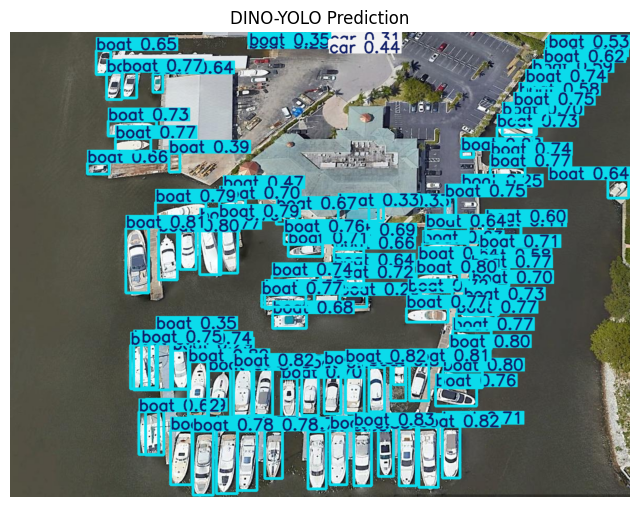

In [13]:
test_dir  = Path("/kaggle/input/skysealand/test/images")
valid_dir = Path("/kaggle/input/skysealand/valid/images")

cands = list(test_dir.glob("*.*")) or list(valid_dir.glob("*.*"))

if cands:
    img_path = random.choice(cands)
    print("Visualising:", img_path.name)

    pred = model.predict(
        source=str(img_path),
        imgsz=640,
        conf=0.25,
        device=0,
        verbose=False
    )[0]

    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:,:,::-1])
    plt.axis("off")
    plt.title("DINO-YOLO Prediction")
    plt.show()


🔹 Loading trained YOLO model …
🔹 Extracting features …


Train features:   0%|          | 0/17 [00:00<?, ?it/s]

Val features:   0%|          | 0/3 [00:00<?, ?it/s]

k-NN accuracy (val): 0.5303


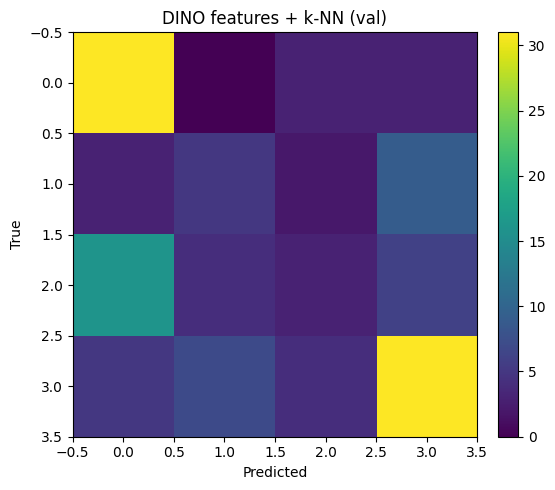

In [14]:
# ================================
# Cell 1 — Load YOLO + Extract Features + k-NN Eval
# ================================
import torch, gc, numpy as np
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from ultralytics import YOLO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
SSL_W = "/kaggle/working/ssl_pretrain_out/exported_models/exported_last.pt"
WORK = Path("/kaggle/working"); WORK.mkdir(exist_ok=True)
DATA_TRAIN = "/kaggle/input/skysealand/train"
DATA_VALID = "/kaggle/input/skysealand/valid"

# --- Helpers ---
def imread_rgb(path: Path): 
    return Image.open(path).convert("RGB")

def yolo_label_for_image(label_file: Path):
    if not label_file.exists(): return None
    ids=[]
    with open(label_file) as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                try: ids.append(int(parts[0]))
                except: pass
    return max(ids, key=ids.count) if ids else None

def list_images_and_labels(split_dir: Path):
    split_dir = Path(split_dir)
    xs, ys = [], []
    images = sorted((split_dir/"images").glob("*.*"))
    for img_path in images:
        lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
        lab = yolo_label_for_image(lb_path)
        if lab is None: continue
        xs.append(img_path); ys.append(lab)
    return xs, np.array(ys, dtype=np.int64)

# -----------------------------
# Feature Hook for YOLOv12
class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        self.feats = list(inputs[0])  # [P3, P4, P5]
        return None
    def close(self): self.handle.remove()

def get_detect_module(model_module):
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__: return last
    except: pass
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__: return m
    return list(model_module.modules())[-1]

def global_pool_concat(feats):
    import torch.nn.functional as F
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

# -----------------------------
# Load YOLO model with DINO weights
from ultralytics.nn.tasks import DetectionModel
torch.serialization.add_safe_globals([DetectionModel])  # allowlist DetectionModel

print("🔹 Loading trained YOLO model …")
feat_model = YOLO("yolo12n.yaml").model.to(device)
state_dict = torch.load(SSL_W, map_location="cpu", weights_only=False)
_ = feat_model.load_state_dict(state_dict, strict=False)
feat_model.eval()
feat_hook = DetectInputHook(get_detect_module(feat_model))

# -----------------------------
# Dataset for feature extraction
base_tfm = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor()])

class ImgDataset(Dataset):
    def __init__(self, paths, tfm): self.paths=paths; self.tfm=tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self,i): return self.tfm(imread_rgb(self.paths[i]))

def extract_feats(paths, bs=64, desc="Extract"):
    ds  = ImgDataset(paths, base_tfm)
    dl  = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
    feats=[]
    for xb in tqdm(dl, total=len(dl), desc=desc, leave=False):
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            _ = feat_model(xb)
            h  = global_pool_concat(feat_hook.feats)  # [B, D]
        feats.append(h.cpu().numpy())
    return np.concatenate(feats, axis=0) if feats else np.zeros((0,1))

# -----------------------------
# Prepare data
train_X, train_y = list_images_and_labels(DATA_TRAIN)
val_X, val_y     = list_images_and_labels(DATA_VALID)

print("🔹 Extracting features …")
train_F = extract_feats(train_X, bs=64, desc="Train features")
val_F   = extract_feats(val_X, bs=64, desc="Val features")

# -----------------------------
# k-NN Evaluation
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(train_F, train_y)
val_pred = knn.predict(val_F)
acc = accuracy_score(val_y, val_pred)
print(f"k-NN accuracy (val): {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(val_y, val_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("DINO features + k-NN (val)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# Cleanup
feat_hook.close(); del feat_model; gc.collect()
if device=="cuda": torch.cuda.empty_cache()


PCA 2D explained variance: 81.12%


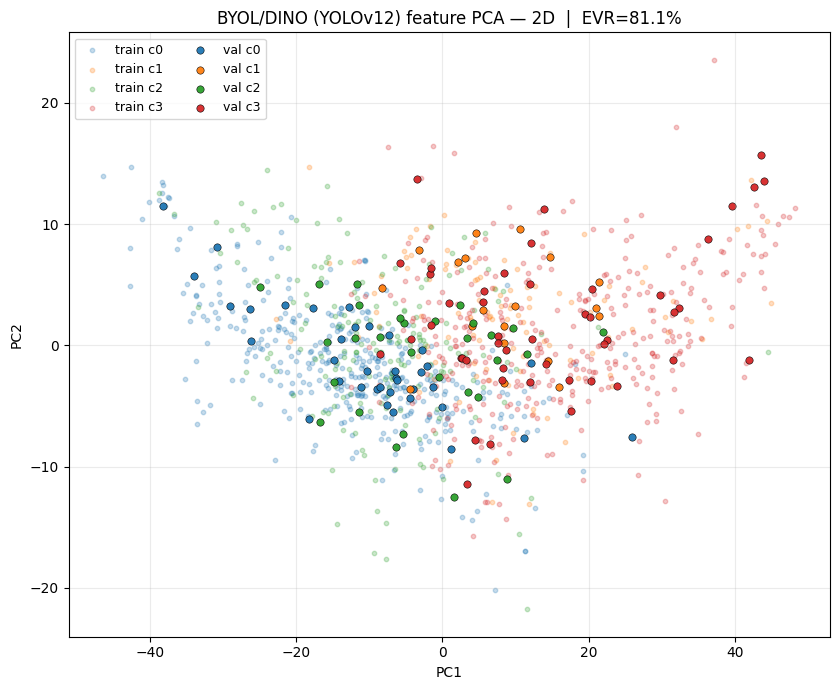

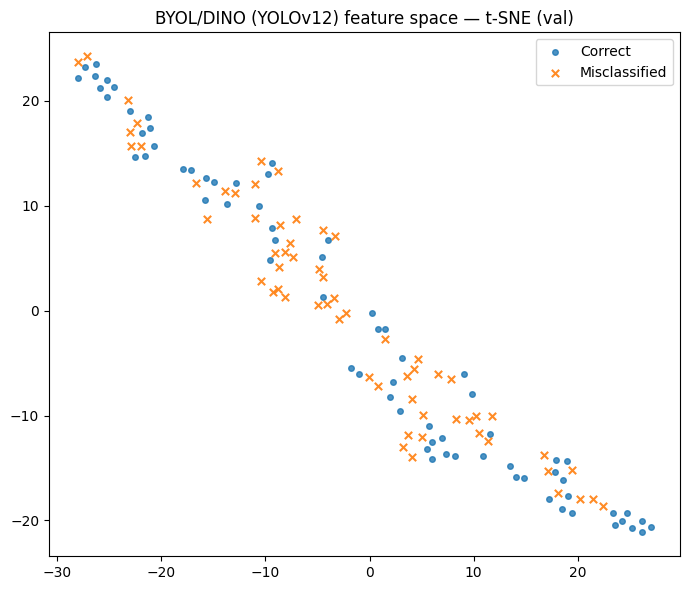

In [15]:
# ================================
# Cell 2 — PCA + t-SNE Visualization of Features
# ================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# --- Standardize features ---
scaler = StandardScaler()
train_Fs = scaler.fit_transform(train_F)
val_Fs   = scaler.transform(val_F)

# --- PCA 2D ---
pca = PCA(n_components=2, random_state=42)
train_P = pca.fit_transform(train_Fs)
val_P   = pca.transform(val_Fs)
evr = pca.explained_variance_ratio_.sum()
print(f"PCA 2D explained variance: {evr*100:.2f}%")

# --- Plot PCA ---
plt.figure(figsize=(8.5,7))
classes = np.unique(np.concatenate([train_y, val_y]))
cmap = plt.get_cmap("tab10")

# train points (faint)
for c in classes:
    idx = np.where(train_y==c)[0]
    if len(idx):
        plt.scatter(train_P[idx,0], train_P[idx,1], s=10, alpha=0.25, color=cmap(int(c)%10), label=f"train c{c}")

# val points (emphasized)
for c in classes:
    idx = np.where(val_y==c)[0]
    if len(idx):
        plt.scatter(val_P[idx,0], val_P[idx,1], s=28, alpha=0.95, edgecolors='k', linewidths=0.4,
                    color=cmap(int(c)%10), marker='o', label=f"val c{c}")

plt.title(f"BYOL/DINO (YOLOv12) feature PCA — 2D  |  EVR={evr*100:.1f}%")
plt.xlabel("PC1"); plt.ylabel("PC2")
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), fontsize=9, ncol=2, frameon=True)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# --- t-SNE 2D ---
if len(val_F) > 10:
    perplex = min(30, max(5, len(val_F)//10))
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                perplexity=perplex, n_iter=1000, random_state=42)
    val_Z = tsne.fit_transform(val_F)

    val_pred = KNeighborsClassifier(n_neighbors=5, n_jobs=-1).fit(train_F, train_y).predict(val_F)
    mistakes = (val_pred != val_y)

    plt.figure(figsize=(7,6))
    plt.scatter(val_Z[~mistakes,0], val_Z[~mistakes,1], s=16, label="Correct", alpha=0.8)
    plt.scatter(val_Z[mistakes,0],   val_Z[mistakes,1],   s=28, marker="x", label="Misclassified", alpha=0.9)
    plt.title("BYOL/DINO (YOLOv12) feature space — t-SNE (val)")
    plt.legend(); plt.tight_layout(); plt.show()
